===================================================
## 3. POD-GAN
#### GAN trained to predict the next time level $\alpha_{n+1} = f(\alpha_n)$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

'3.POD-GAN.ipynb'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

## Load data

In [5]:
pod_coeffs = np.loadtxt('POD_coeffs.csv', delimiter=',') 

X_pod = np.transpose(pod_coeffs)
step = 1
times = np.arange(0, len(X_pod), step, dtype="float64")

In [6]:
X_pod.shape

(999, 5)

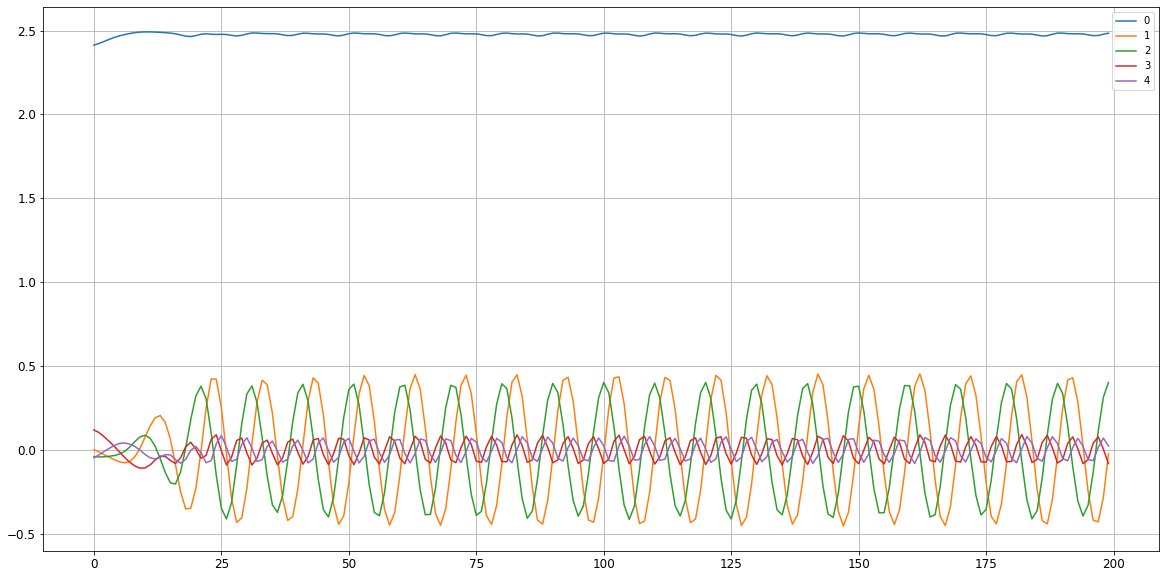

In [8]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times[:200], X_pod[:200]);
ax.grid()
ax.legend(range(5))

## Prepare data

In [9]:
codings_size = X_pod.shape[1]
X_pod.shape

(999, 5)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_pod_scaled = scaler.fit_transform(X_pod)
np.allclose(X_pod, scaler.inverse_transform(X_pod_scaled))

True

In [11]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step]) # [start_idx:end_idx:step]
    return np.array(X_train_concat)

In [23]:
ntimes = 5 # Consecutive times for the GAN
time_step = 1 # step between time levels

X_train_concat = concat_timesteps(X_pod_scaled, ntimes, time_step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes)

(994, 5, 5)


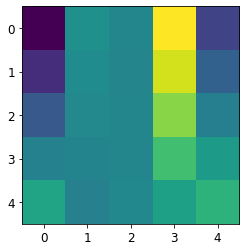

In [24]:
print(X_pod_concat.shape)
plt.imshow(X_pod_concat[0, :, :])

## Train the GAN

In [34]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 5, 5, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
for data in train_dataset:
    print(data)
    break

tf.Tensor(
[[[[0.85088927]
   [0.8992698 ]
   [0.21386662]
   [0.6885476 ]
   [0.87965745]]

  [[0.84844893]
   [0.64585626]
   [0.03391567]
   [0.22960053]
   [0.8292416 ]]

  [[0.79323983]
   [0.32760334]
   [0.03733157]
   [0.13349916]
   [0.3152939 ]]

  [[0.7161699 ]
   [0.08202469]
   [0.22890134]
   [0.52607936]
   [0.04407104]]

  [[0.7034076 ]
   [0.00535844]
   [0.532071  ]
   [0.8426705 ]
   [0.39562812]]]


 [[[0.89080095]
   [0.88243484]
   [0.81884676]
   [0.42200598]
   [0.05212341]]

  [[0.86092216]
   [0.9891522 ]
   [0.53621477]
   [0.7911017 ]
   [0.29635593]]

  [[0.8580036 ]
   [0.91403246]
   [0.24653481]
   [0.714242  ]
   [0.8040004 ]]

  [[0.86202973]
   [0.6827102 ]
   [0.05806549]
   [0.27904275]
   [0.8315917 ]]

  [[0.8211446 ]
   [0.37344763]
   [0.04045875]
   [0.09390831]
   [0.3640598 ]]]


 [[[0.8622272 ]
   [0.82621056]
   [0.14394547]
   [0.53122306]
   [0.90178204]]

  [[0.85094464]
   [0.5459116 ]
   [0.0262856 ]
   [0.12775648]
   [0.64966315]]

 

In [35]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*4*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 4, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model

In [36]:
generator = make_generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5120)              512000    
_________________________________________________________________
batch_normalization_3 (Batch (None, 5120)              20480     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 5120)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 5, 4, 128)         294912    
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5, 4, 128)        

(1, 9, 15, 1)


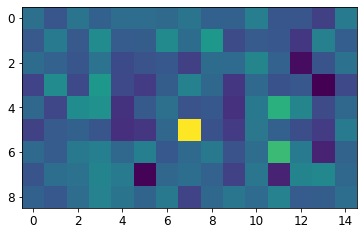

In [37]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0])

In [38]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[9, 15, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [39]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 8, 64)          640       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 5, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5, 4, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)             

In [40]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0018304]], shape=(1, 1), dtype=float32)


In [41]:
gan = keras.models.Sequential([generator, discriminator])

In [42]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [43]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [44]:
# We will reuse this seed overtime 
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [45]:
# logs to follow losses on tensorboard
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/' + notebookName[:-6] + '/generator'
discriminator_log_dir = './logs/' + notebookName[:-6] + '/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)


In [47]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
            
        with generator_summary_writer.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator", "{}: {:.6f}".format(discriminator.metrics_names[0], hist[-1][1]), end=' - ')
        print("generator", "{}: {:.6f}".format(gan.metrics_names[0], hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform((generator.predict(seed).reshape(num_examples_to_generate*ntimes,15)+1)/2)
            X_generated = pca_compress.inverse_transform(X_generated)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.show() 
                    
            # Save model
            gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist


In [48]:
hist = train(train_dataset, epochs=55000)

Epoch 1/55000


ValueError: in converted code:

    <ipython-input-46-48704debee81>:10 train_step  *
        real_output = discriminator(batch, training=True)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\sequential.py:256 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:812 __call__
        self.name)
    D:\anaconda3\envs\py3ml\lib\site-packages\tensorflow_core\python\keras\engine\input_spec.py:213 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_3 is incompatible with the layer: expected axis -1 of input shape to have value 2560 but received input with shape [256, 768]


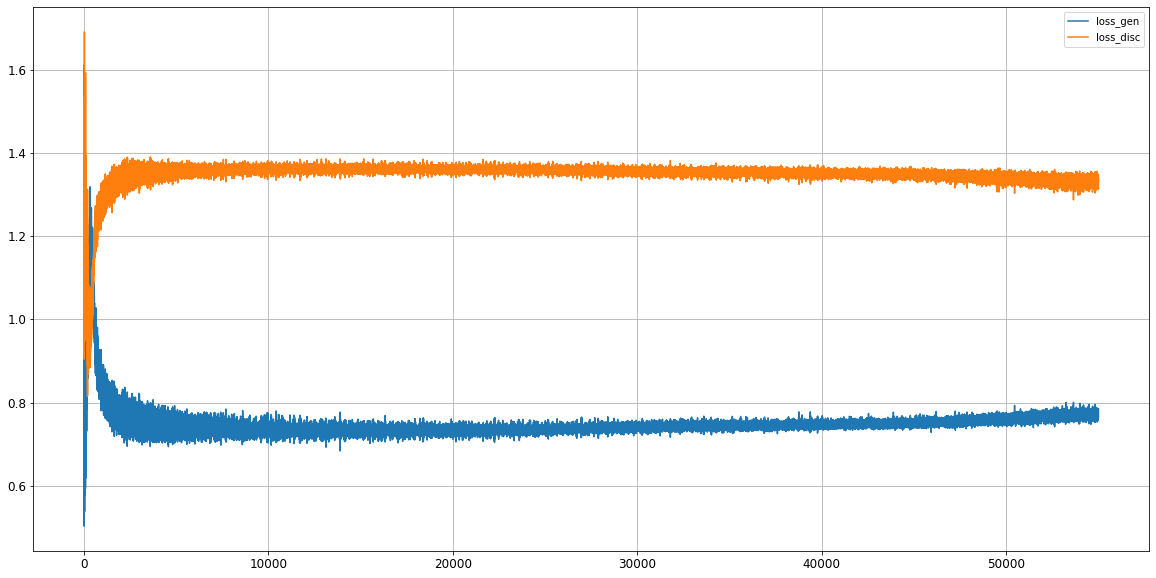

In [32]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

In [33]:
#from tensorflow.keras.models import load_model
import joblib
joblib.dump(scaler, "scaler-tfex.pkl")
gan.save("gan-tfex.h5")

In [34]:
np.random.seed(10)
tf.random.set_seed(10)

noise = tf.random.normal(shape=[1, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated[X_generated<0.0] = 0.0

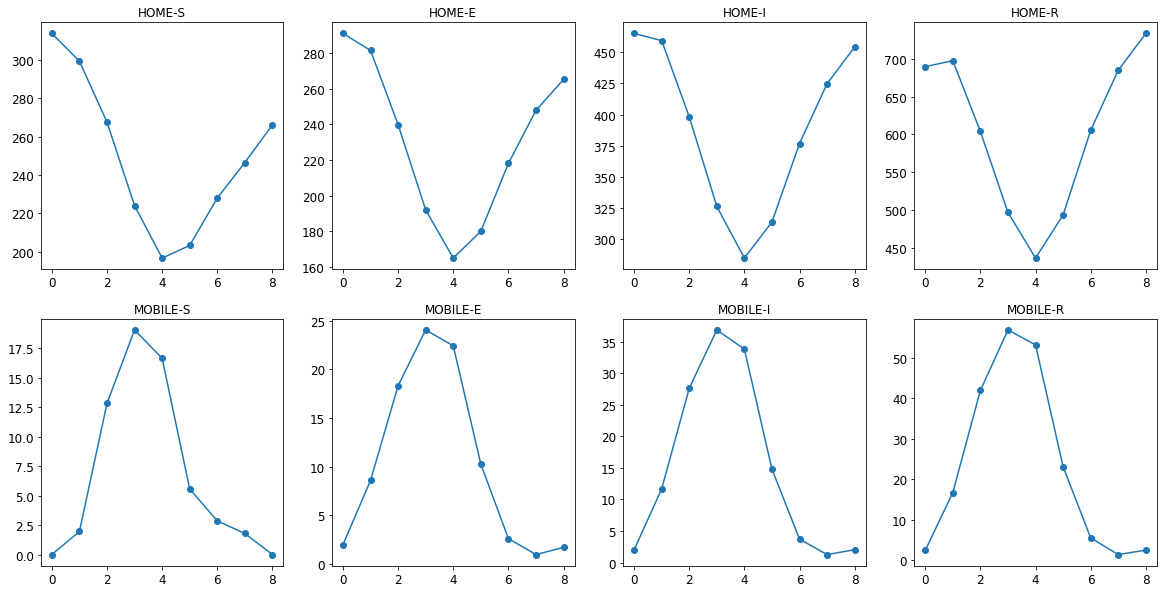

In [35]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

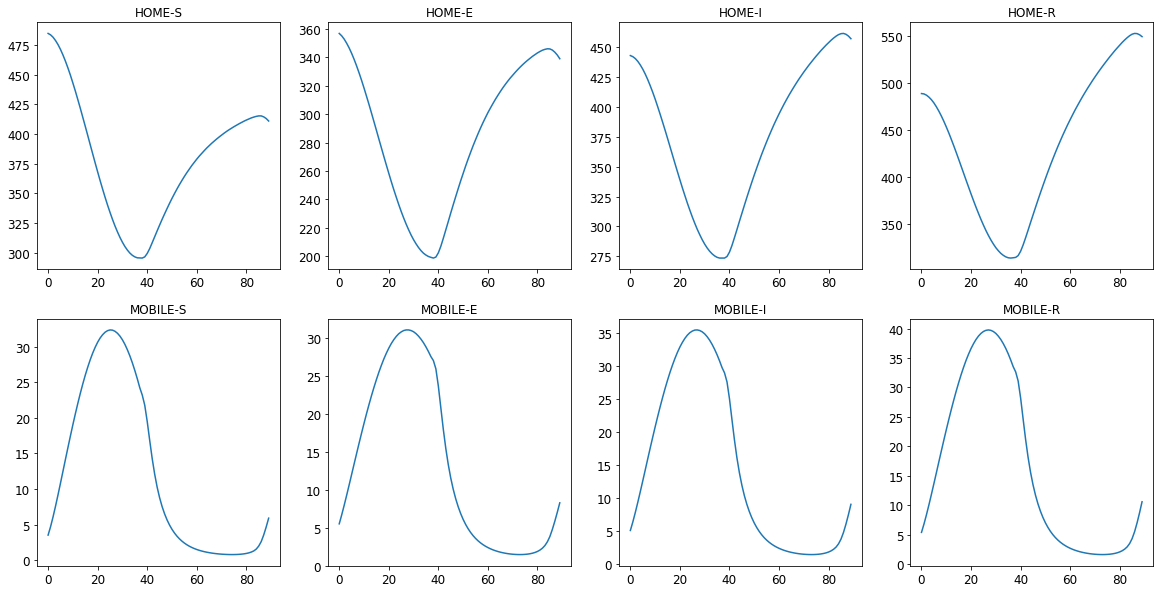

In [36]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[2930:3020,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

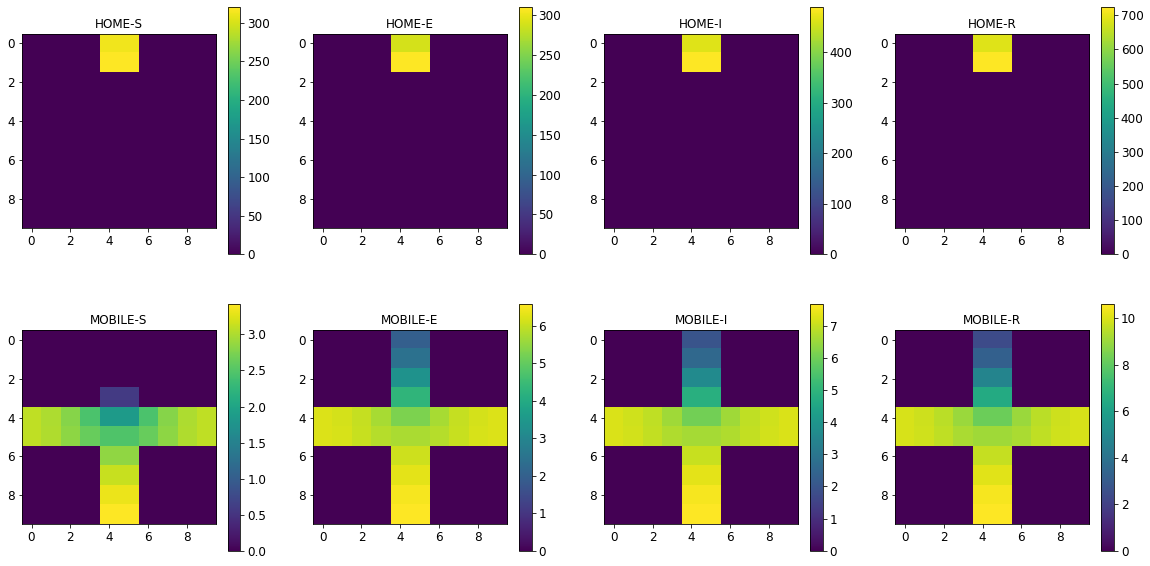

In [37]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[0,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

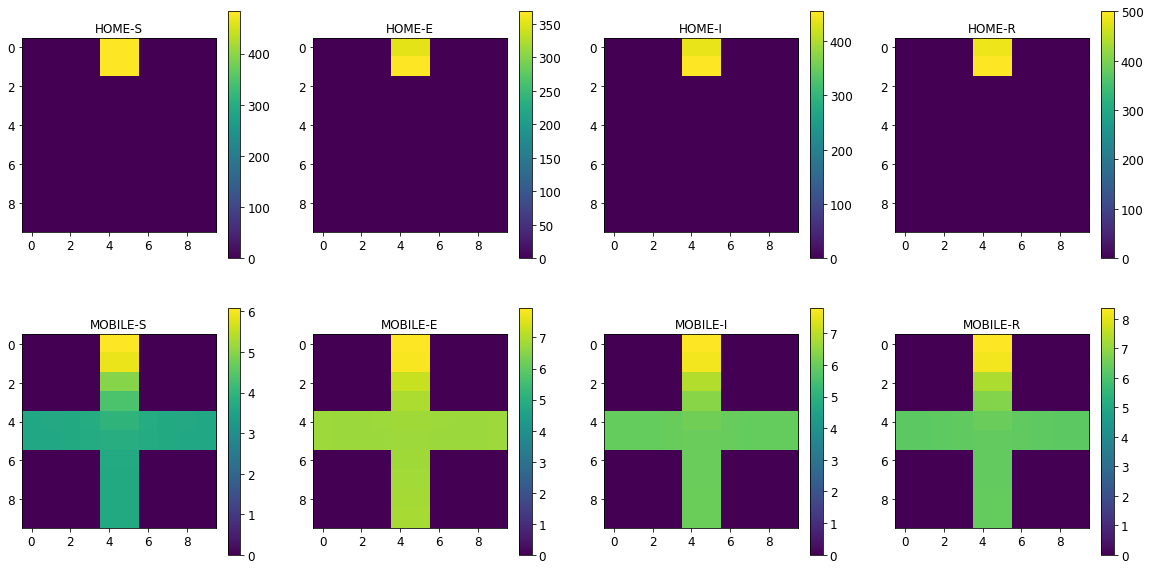

In [38]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[2932,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

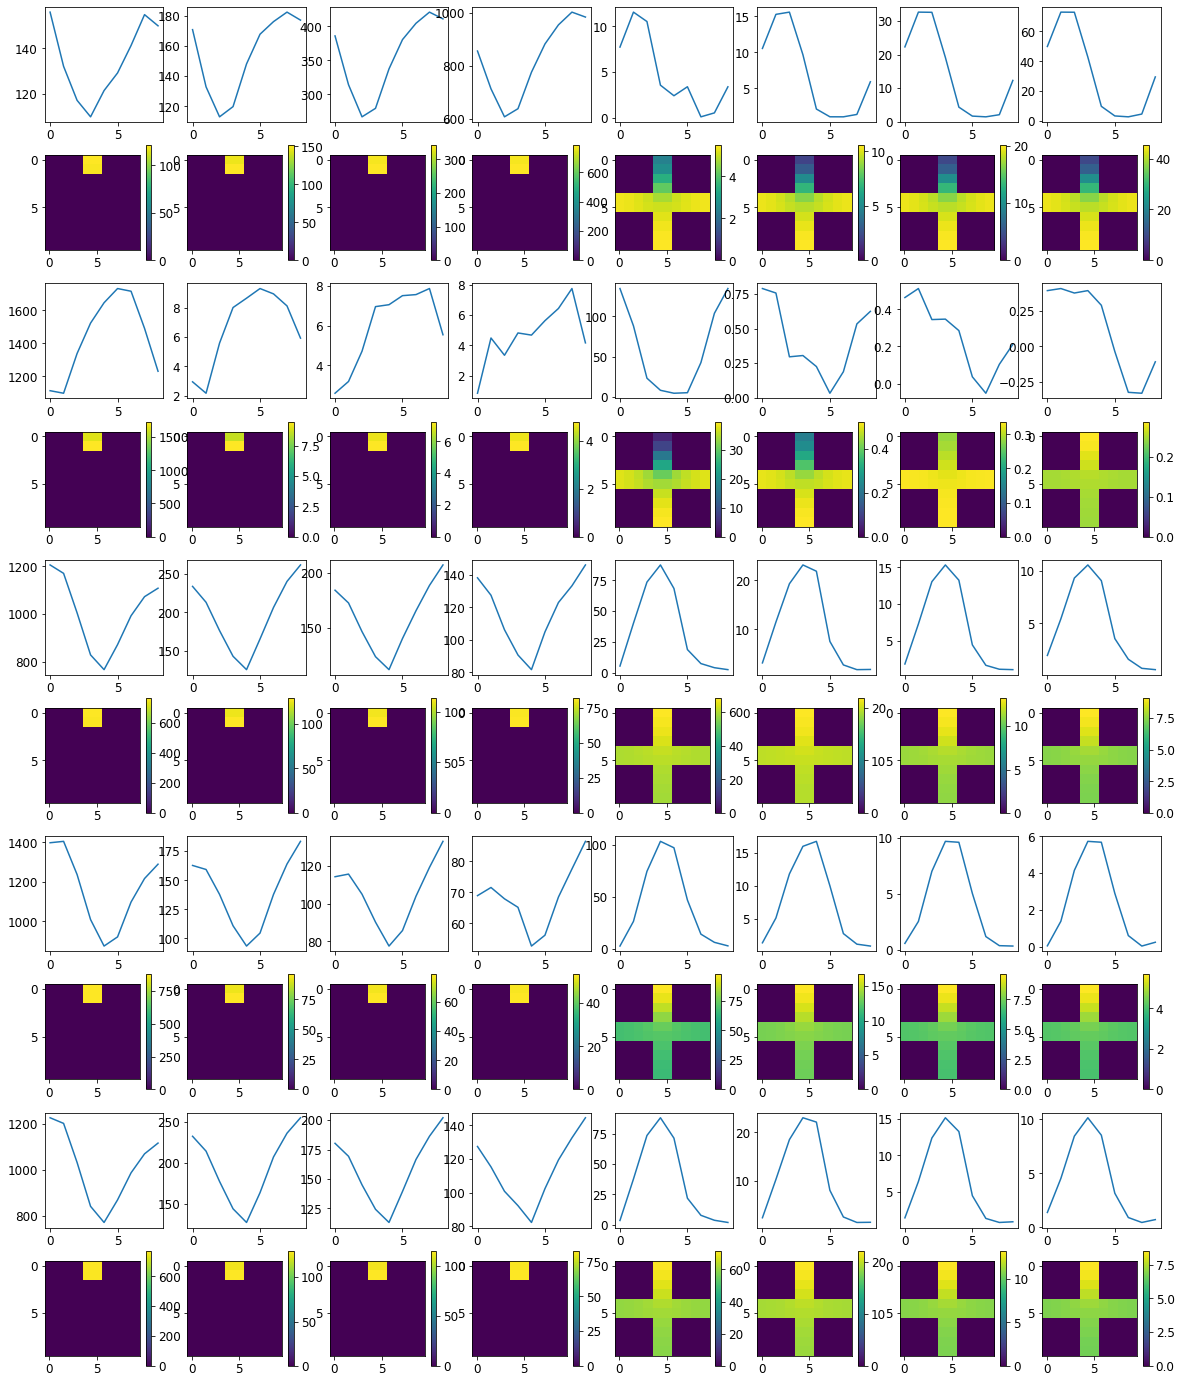

In [39]:
npredict = 5
noise = tf.random.normal(shape=[npredict, latent_space])
X_generated = scaler.inverse_transform((gan.layers[0].predict(noise).reshape(npredict*ntimes,15)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
